# TouchPass Analysis

This analysis contains TouchPass transactions from September 8, 2020 through February 28, 2021.

In [35]:
# Import libraries
import os
import json
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime as dt
import timeit
import seaborn as sns
import calplot
import matplotlib.pyplot as plt
import ipyleaflet

%matplotlib inline
pd.options.display.max_columns = 999

In [2]:
# create timer
def get_time(timer):
    minutes, seconds = int(np.floor(timer)), round(np.ndarray.item(timer % 1) * 60)
    return [minutes, seconds]

In [3]:
# define parameters
url = 'https://touchpass.com/ams/rest/v1/reporting/faretx/'
api_key = os.environ.get('TOUCHPASS_API_KEY')
start_date = '2020-09-08T10:00:00Z'
end_date = '2021-02-28T04:00:00Z'

headers = {
    'accept': 'application/json',
    'Api-Token': api_key,
    'Agency-ID': '9K7A4H9JHRVQ'
}

In [4]:
# start timer
start = timeit.default_timer()

# call api and save to variable
response = requests.get(url + start_date + '/' + end_date, headers=headers).json()

# stop timer
stop = timeit.default_timer()

# calculate time
timer = np.array([(stop-start) / 60])
min_sec = get_time(timer)
minutes, seconds = min_sec[0], min_sec[1]

print('Data successfully fetched.... \nTotal time:', minutes, 'minutes', seconds, 'seconds')

Data successfully fetched.... 
Total time: 0 minutes 7 seconds


In [5]:
# write response to dataframe
df = pd.DataFrame(response)

df.head(3)

,txId,ts,type,mediaUsed,mediaType,cardNumber,fareType,accountId,stopName,stopId,routeName,latitude,longitude,reader,vehicle,passUsed,readerPosition,fare
0,5030000000004008,2020-09-08T10:00:14.653Z,TRIP_PASS,HOUSE,HOUSE_CARD,8029085186424157,Full Fare,2713645.0,Freeman Mill & Coliseum (West),139,2,36.043839,-79.815046,H2R257,TransLoc Vehicle: 5929 (4011471),Full Fare 10 Ride,0,0
1,5330000000001867,2020-09-08T10:04:24.979Z,STORED_VALUE,HOUSE,HOUSE_CARD,8042289049935002,TriadX,2509447.0,Mount Airy Park & Ride,168,6,36.480591,-80.605441,H2R248,TransLoc Vehicle: 5931 (4011479),NaN,0,250
2,5030000000004009,2020-09-08T10:04:46.046Z,TRIP_PASS,HOUSE,HOUSE_CARD,8070364659315533,Half Priced,2720702.0,Four Seasons Mall,153,2,36.040488,-79.841648,H2R257,TransLoc Vehicle: 5929 (4011471),Half Fare 10 Ride,0,0


Now that we've read in the data, let's learn a little more about it...

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50777 entries, 0 to 50776
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   txId            50777 non-null  int64  
 1   ts              50777 non-null  object 
 2   type            50777 non-null  object 
 3   mediaUsed       50777 non-null  object 
 4   mediaType       50771 non-null  object 
 5   cardNumber      50771 non-null  object 
 6   fareType        50777 non-null  object 
 7   accountId       50771 non-null  float64
 8   stopName        21447 non-null  object 
 9   stopId          21447 non-null  object 
 10  routeName       50775 non-null  object 
 11  latitude        50777 non-null  float64
 12  longitude       50777 non-null  float64
 13  reader          50777 non-null  object 
 14  vehicle         16571 non-null  object 
 15  passUsed        19782 non-null  object 
 16  readerPosition  50777 non-null  int64  
 17  fare            50777 non-null 

We can see that there are almost 51,000 records in the dataset. It looks like we're missing quite a few records with the stopName, stopId, vehicle and passUsed columns. We'll dig into that in a moment. But first let's add a few new attributes to help with the analysis.

### Data cleaning

In [7]:
# Create new fields
df['ts'] = pd.to_datetime(df['ts'])
df['date'] = df['ts'].dt.tz_convert('US/Eastern')
df['date_only'] = df['date'].dt.date
df['time_only'] = [dt.datetime.time(d) for d in df['date']]
df['day_of_week'] = df['date'].dt.day_name()
df['month'] = df['date'].dt.month

# create spatial dataframe
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df['longitude'], df['latitude'])
)

gdf = gdf.set_crs(epsg='4326')

gdf.head(3)

,txId,ts,type,mediaUsed,mediaType,cardNumber,fareType,accountId,stopName,stopId,routeName,latitude,longitude,reader,vehicle,passUsed,readerPosition,fare,date,date_only,time_only,day_of_week,month,geometry
0,5030000000004008,2020-09-08 10:00:14.653000+00:00,TRIP_PASS,HOUSE,HOUSE_CARD,8029085186424157,Full Fare,2713645.0,Freeman Mill & Coliseum (West),139,2,36.043839,-79.815046,H2R257,TransLoc Vehicle: 5929 (4011471),Full Fare 10 Ride,0,0,2020-09-08 06:00:14.653000-04:00,2020-09-08,06:00:14.653000,Tuesday,9,POINT (-79.81505 36.04384)
1,5330000000001867,2020-09-08 10:04:24.979000+00:00,STORED_VALUE,HOUSE,HOUSE_CARD,8042289049935002,TriadX,2509447.0,Mount Airy Park & Ride,168,6,36.480591,-80.605441,H2R248,TransLoc Vehicle: 5931 (4011479),NaN,0,250,2020-09-08 06:04:24.979000-04:00,2020-09-08,06:04:24.979000,Tuesday,9,POINT (-80.60544 36.48059)
2,5030000000004009,2020-09-08 10:04:46.046000+00:00,TRIP_PASS,HOUSE,HOUSE_CARD,8070364659315533,Half Priced,2720702.0,Four Seasons Mall,153,2,36.040488,-79.841648,H2R257,TransLoc Vehicle: 5929 (4011471),Half Fare 10 Ride,0,0,2020-09-08 06:04:46.046000-04:00,2020-09-08,06:04:46.046000,Tuesday,9,POINT (-79.84165 36.04049)


Let's look at that missing data...

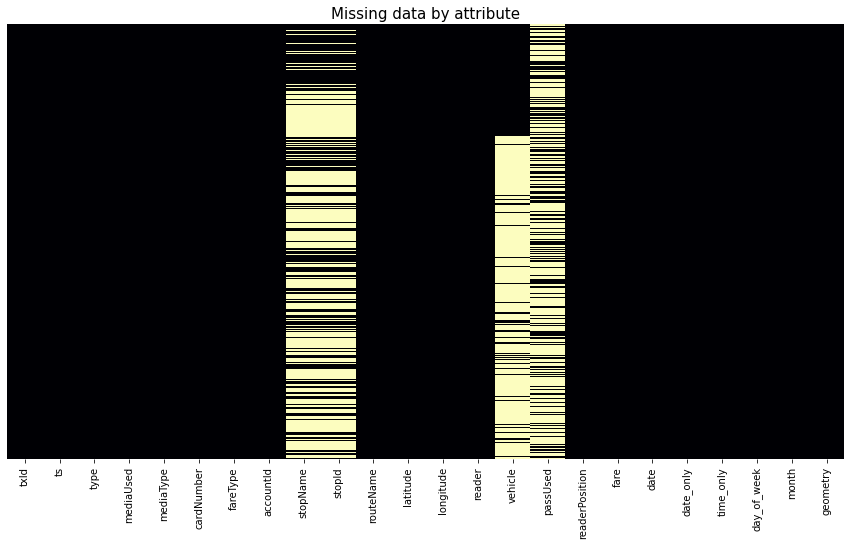

In [8]:
plt.figure(figsize=(15,8))
ax = sns.heatmap(gdf.isnull(), cbar=False, cmap='magma')
plt.yticks([])
plt.title('Missing data by attribute', fontsize=15)
plt.show()

The plot above shows missing data by attribute. We can see that `stopName` and `stopId` are missing the same records. What's interesting is we appear to have the `latitude` and `longitude` values for those records. We'll come back to the latitude and longitude attributes. But first, let's look at the missing data by date.

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


(<Figure size 900x244.8 with 3 Axes>,
 array([<AxesSubplot:ylabel='2020'>, <AxesSubplot:ylabel='2021'>],
       dtype=object))

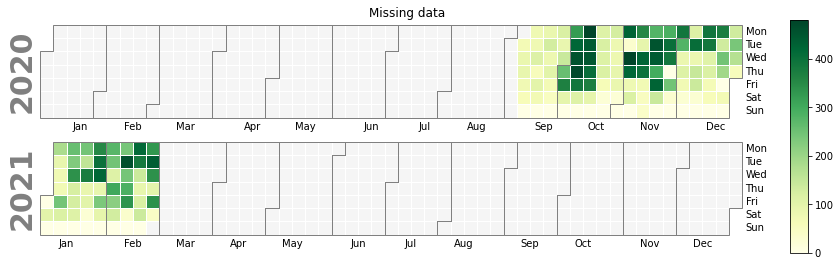

In [9]:
missing_data_by_date = gdf[gdf['stopName'].isnull()].groupby('date_only').size()
missing_data_by_date.index = pd.to_datetime(missing_data_by_date.index)

calplot.calplot(missing_data_by_date, edgecolor='gray', suptitle='Missing data', cmap='YlGn')

The calendar heatmaps above show days where the data set is missing values from the `stopName` attribute. There appear to be clusters of the missing data. For example, the first two and a half weeks of October are missing around 400 data points. The last two weeks of October look great. November is a little more spotty. For example, Mondays, Wednesdays and Thursdays do not look that great. December appears to have better data collection. January is not too bad except for the last three Wednesdays. Mondays and Tuesdays in February appear to be missing quite a bit of data too.

Let's come back to the `latitude` and `longitude` columns.

In [10]:
missing_stop_name = gdf[gdf['stopName'].isnull()]

missing_stop_name[['latitude', 'longitude']][:10]

,latitude,longitude
30,0.000000,0.000000
31,0.000000,0.000000
32,36.480801,-80.605804
33,36.480801,-80.605804
65,0.000000,0.000000
73,0.000000,0.000000
79,35.957325,-80.007321
97,0.000000,0.000000
106,0.000000,0.000000
107,0.000000,0.000000


It looks like there are some unusual values for these two attributes where `stopName` is missing. We will be able to plot the records where `stopName` is missing for those where `latitude` and `longitude` are not `0.000000`.

Let's get a count of these records...

In [11]:
no_lat = missing_stop_name[missing_stop_name['latitude'] == 0.000000]
lat = missing_stop_name[missing_stop_name['latitude'] != 0.000000]

print('There are {:,} records where there is no `latitude` value'.format(len(no_lat)))
print('There are {:,} records where there is a `latitude` value'.format(len(lat)))

There are 5,285 records where there is no `latitude` value
There are 24,045 records where there is a `latitude` value


That looks like great news. Let's plot those observations with valid `latitude` and `longitude` values.

In [37]:
m = Map(
    basemap=basemaps.Esri.WorldTopoMap,
    center=(36.086954, -79.916494), 
    zoom=9
)

display(m)

Map(center=[36.086954, -79.916494], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

Let's see what values for `routeName` there are...

In [13]:
len_of_gdf = len(gdf)

by_route = gdf.rename(
    columns={'routeName': 'Route ID'}
).groupby('Route ID').size().sort_values(ascending=False).to_frame()

by_route.rename(columns={0: 'Count'}, inplace=True)
by_route['Percentage'] = by_route['Count'] / len_of_gdf
by_route.style.format({'Count': '{:,}', 'Percentage': '{:.2%}'})

,Count,Percentage
Route ID,,
2,"13,336",26.26%
DEFAULT,"8,543",16.82%
1,"7,340",14.46%
3,"6,015",11.85%
4,"5,043",9.93%
17,"1,630",3.21%
21,"1,324",2.61%
22,"1,220",2.40%
22/23,963,1.90%


In [14]:
funny_routes = gdf.loc[
    (gdf['routeName'].str.startswith('ID')) |
    (gdf['routeName'] == 'DEFAULT'),
    :
]

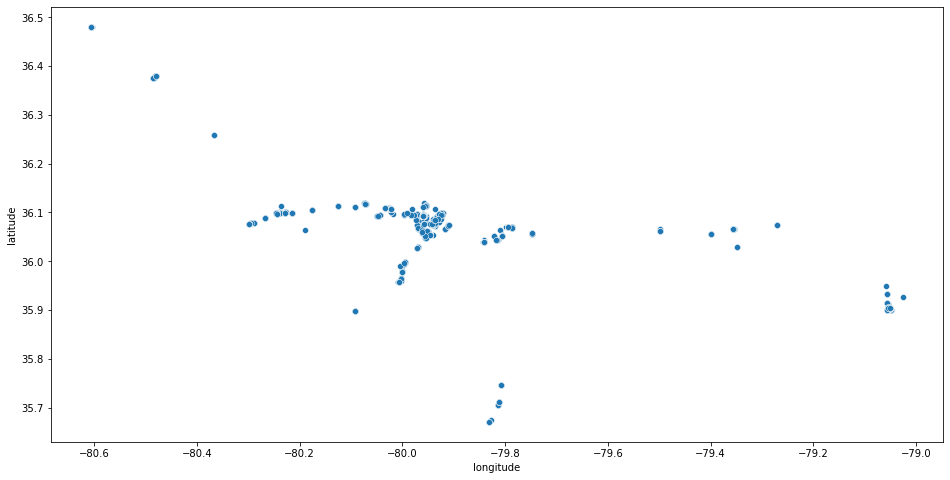

In [15]:
z = funny_routes[funny_routes['latitude'] != 0.000000]

plt.figure(figsize=(16,8))
ax = sns.scatterplot(x=z['longitude'], y=z['latitude'])
plt.show()

### Exploratory data analysis


Let's start off with some simple analysis so we can understand the data set.

In [16]:
# get number of unique users
unique_users = len(gdf['cardNumber'].unique())

print('There are {:,} unique card numbers in the data set.'.format(unique_users))

There are 2,906 unique card numbers in the data set.


In [17]:
cardnum_by_count = gdf['cardNumber'].value_counts().to_frame().rename(columns={'cardNumber': 'Count'})
cardnum_by_count

,Count
8003924580285816,502
8008404267993987,487
8066147570086432,456
8074004896286800,450
7086152527269725,434
...,...
9028879885943155,1
9053777949854608,1
9067864670244599,1
9003461124146038,1


Here we can see that account `8003924580285816` has the most transactions in the data set. This passenger tapped their card/phone 502 times. We'll dig into this passenger a bit later. We can also see that there are a number of passengers who have only used their TouchPass account once. Let's see how many there are...

In [18]:
count_one_time_user = len(cardnum_by_count[cardnum_by_count['Count']== 1])
one_time_user_percent = count_one_time_user / unique_users

print('There are {:,} users who have only tapped once in the data set.'.format(count_one_time_user))
print('This accounts for {0:.0%} of the data.'.format(one_time_user_percent))

There are 1,101 users who have only tapped once in the data set.
This accounts for 38% of the data.


Let's select all those passengers who have only used their TouchPass account once in the data set and see if the usage was concentrated around a particular promotional event or if it's totally random...

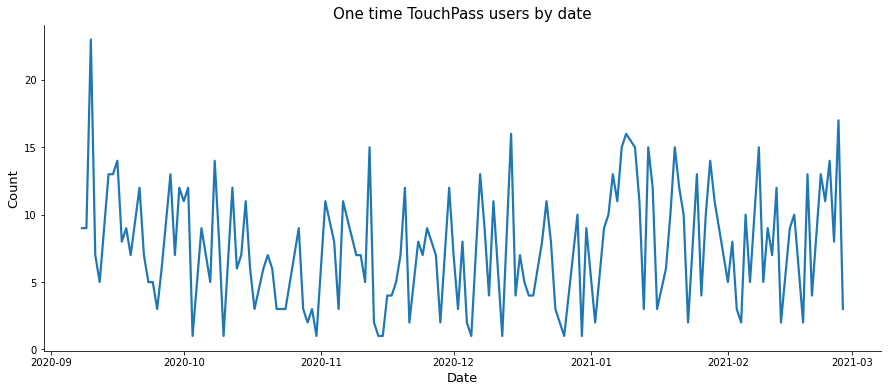

In [19]:
one_time_user = list(cardnum_by_count[cardnum_by_count['Count'] == 1].index)
one_time_user_by_date = gdf[gdf['cardNumber'].isin(one_time_user)].groupby('date_only').size()

plt.figure(figsize=(15,6))
ax = sns.lineplot(data=one_time_user_by_date, lw=2.2)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.title('One time TouchPass users by date', fontsize=15)
sns.despine()
plt.show()

There is one day at the start of the data set that stands out as having a lot of one-time users. Let's grab that date and confer with Operations on the date in question.

In [20]:
most_one_time_users = one_time_user_by_date.idxmax()

most_one_time_users.strftime('%A %m-%d-%Y')

'Thursday 09-10-2020'




Let's come back to user 8003924580285816 who is the most frequent TouchPass user in the data set.

In [21]:
freq_user = gdf[gdf['cardNumber'] == '8003924580285816']
freq_user.head(3)

,txId,ts,type,mediaUsed,mediaType,cardNumber,fareType,accountId,stopName,stopId,routeName,latitude,longitude,reader,vehicle,passUsed,readerPosition,fare,date,date_only,time_only,day_of_week,month,geometry
115,4870000000003853,2020-09-08 12:03:48.683000+00:00,TRIP_PASS,HOUSE,HOUSE_CARD,8003924580285816,Full Fare,2712931.0,Camco (Landmark Rd Access),232,20,36.095029,-79.976960,H2R122,TransLoc Vehicle: 1901 (4017887),Full Fare 10 Ride,0,0,2020-09-08 08:03:48.683000-04:00,2020-09-08,08:03:48.683000,Tuesday,9,POINT (-79.97696 36.09503)
121,5030000000004026,2020-09-08 12:17:11.175000+00:00,TRANSFER,HOUSE,HOUSE_CARD,8003924580285816,Full Fare,2712931.0,Coble Transportation Center,100,2,36.093629,-79.959345,H2R257,TransLoc Vehicle: 5929 (4011471),NaN,0,0,2020-09-08 08:17:11.175000-04:00,2020-09-08,08:17:11.175000,Tuesday,9,POINT (-79.95934 36.09363)
382,5230000000002051,2020-09-08 21:53:55.206000+00:00,TRIP_PASS,HOUSE,HOUSE_CARD,8003924580285816,Full Fare,2712931.0,Freeman Mill & Florida (West),200,2,36.052587,-79.806510,H2R263,TransLoc Vehicle: 2003 (4018753),Full Fare 10 Ride,0,0,2020-09-08 17:53:55.206000-04:00,2020-09-08,17:53:55.206000,Tuesday,9,POINT (-79.80651 36.05259)


In [22]:
freq_user['stopName'].value_counts().to_frame().rename(columns={'stopName': 'Count'})

,Count
Coble Transportation Center,125
Camco (Landmark Rd Access),46
Freeman Mill & Florida (West),43
Greensboro Depot,10
Four Seasons Mall,3


The table above shows us which stops user `8003924580285816` utilizes in the PART system. The Coble Transportation Center is the most frequently used stop. It appears that the user also utilizes Route 20 to access the Camco stop as well as Route 2 to access the other three stops. Let's break the usage down by the day of the week.

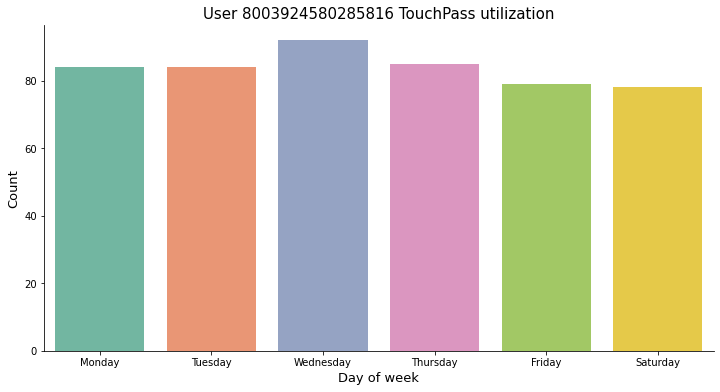

In [23]:
freq_user_by_dow = freq_user.groupby('day_of_week').size().to_frame().rename(columns={0: 'Count'})
order = [
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'
]

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=freq_user_by_dow.index,
    y=freq_user_by_dow['Count'],
    data=freq_user_by_dow,
    order=order,
    palette='Set2'
)
plt.xlabel('Day of week', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.title('User 8003924580285816 TouchPass utilization', fontsize=15)
sns.despine()
plt.show()

It seems that this passenger is a daily rider. They utilize PART Express consistently

Let's examine the passengers and trips who utilize half-priced fares.

In [24]:
# get records where half fare was used
half_price_fares = gdf[gdf['fareType'] == 'Half Priced']

# get the number of unique users who use half fares
half_price_fare_user = len(half_price_fares['cardNumber'].unique())
half_price_fare_percent = half_price_fare_user / unique_users

In [25]:
print('There are {:,} users who utilize half-priced fares in the data set.'.format(half_price_fare_user))
print('This accounts for {0:.0%} of the data.'.format(half_price_fare_percent))

There are 274 users who utilize half-priced fares in the data set.
This accounts for 9% of the data.


In [26]:
# select the stops and the number of times they appear in the data set
half_price_fare_stops = half_price_fares['stopName'].value_counts().to_frame().rename(columns={'stopName': 'Count'})
# create new attribute to rank the stops by appearance
half_price_fare_stops['Rank'] = half_price_fare_stops['Count'].rank(method='max', ascending=False)

# show table
half_price_fare_stops[:25]

,Count,Rank
Coble Transportation Center,2933,1.0
Greensboro Depot,882,2.0
Winston-Salem Transportation Center (L-1),532,3.0
High Point Terminal (Outer Slip),314,4.0
Four Seasons Mall,239,5.0
5th Street (WS Journal),234,6.0
E Washington & Eugene St,136,7.0
Sutton Way & Highway 68 N,64,8.0
Motel 6,58,9.0
FedEx Ground (EB),55,10.0


The table above shows the stops that a half-price fare was utilized at. We can see that the CTC ranks 1st with 2,933 half-price fares. What's interesting is the VA Health Care Center in Kernersville is tied for 16th place with 33 half-price boardings. I wonder if there's more utilization of this stop. Let's find out...

In [27]:
taps_at_va = len(gdf[gdf['stopName'] == 'VA Health Care Center'])
va_passengers = gdf.loc[(gdf['stopName'] == 'VA Health Care Center')]['cardNumber'].unique()

print('There have been {} taps at the VA Health Care Center from {} unique passengers.'.format(taps_at_va, len(va_passengers)))

There have been 61 taps at the VA Health Care Center from 38 unique passengers.


Let's find out which of those passengers is not utilizing half-priced fare.

In [28]:
va_full_fare = gdf.loc[
    (gdf['stopName'] == 'VA Health Care Center') & 
    (gdf['fareType'] != 'Half Priced'),
'cardNumber'].unique()

va_full_fare

array(['9098348745820586', '8009041252189889', '9021031180957202',
       '7086152527269725', '8016324348609677', '9010537042496950',
       '9013090472558474', '9081056967383105', '9049064298848094',
       '7876884406922446', '8090351248600109', '9018747586516848',
       '9088110355375877', '7843308130493656', '9085652588486313',
       '9017040585230053', '9006741614372716', '9059831019948099',
       '9053542517271142'], dtype=object)

There are 19 unique TouchPass users who have boarded at the VA Health Care Center and have not utilized the half-priced fare. These card numbers can easily be written to an Excel file for Call Center staff to follow up with.